# Mask R-CNN - Train on Jets

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/camila/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
class JetsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "jets"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64
    
    # No mini-masks
    USE_MINI_MASK = False

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32
    #XXXXXXXXXXXXXXXXXXX Change?

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = JetsConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]
 [ 1  1]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  64
IMAGE_MIN_DIM                  64
IMAGE_PADDING                  True
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           jets
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_POSITIV

## Notebook Preferences

In [5]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class JetsDataset(utils.Dataset):
    """
    ...
    """

    def load_data(self, m, images, labels):
        self.add_class('jets', 1, 'jet')
        
        for i in range(m):
            image = images[i,:,:].reshape(64,64)
            label = labels[i,:,:].reshape(64,64)
            self.add_image('jets', i, path=None, image=image, label=label)
        
    
    def load_image(self, image_id):
        """
        Returns the input image
        """
        info = self.image_info[image_id]
        image = info['image']
        
        image = np.round(image * (255/np.max(image)))
        
        image3D = np.zeros((image.shape[0], image.shape[1], 3))
        image3D[:,:,0] = image
        image3D[:,:,1] = image
        image3D[:,:,2] = image

        image3D = image3D.astype(np.uint8)
        
        return image3D
        

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "jets":
            return info["image"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        label = info['label']
        shape = label.shape
        num_jets = np.max(label).astype(int)
        masks = np.zeros((shape[0], shape[1], num_jets)).astype(np.int32)
        
        for i in range(num_jets):
            masks[:,:,i] = (label == i+1)
                      
        class_ids = np.ones(num_jets, dtype=np.int32)
        
        return masks, class_ids

In [6]:
images = np.load('pixel_image_pt.npy')
labels = np.load('labels_20pt.npy')

#separating training/validation
train_cutoff = int(0.99 * images.shape[0])
images_train = images[:train_cutoff,:,:]
images_val = images[train_cutoff:,:,:]
labels_train = labels[:train_cutoff,:,:]
labels_val = labels[train_cutoff:,:,:]

# Training dataset
m_train = images_train.shape[0]
dataset_train = JetsDataset()
dataset_train.load_data(m_train, images_train, labels_train)
dataset_train.prepare()

# Validation dataset
m_val = images_val.shape[0]
dataset_val = JetsDataset()
dataset_val.load_data(m_val, images_val, labels_val)
dataset_val.prepare()

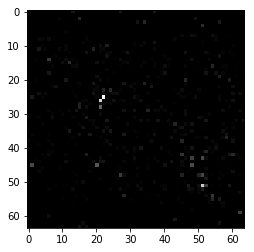

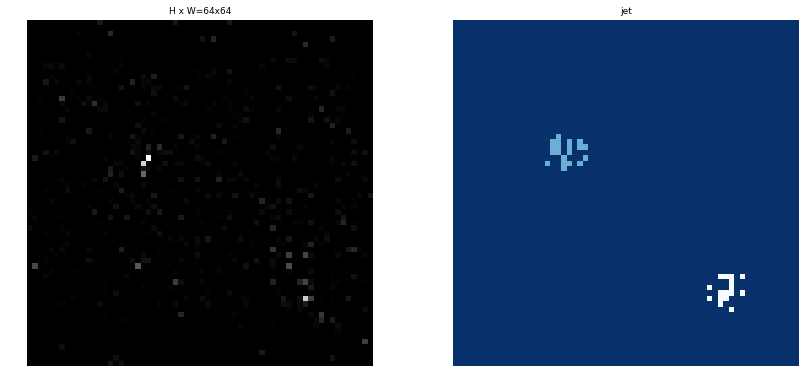

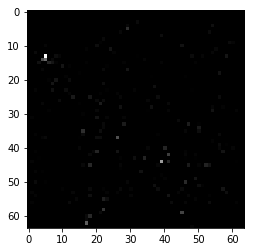

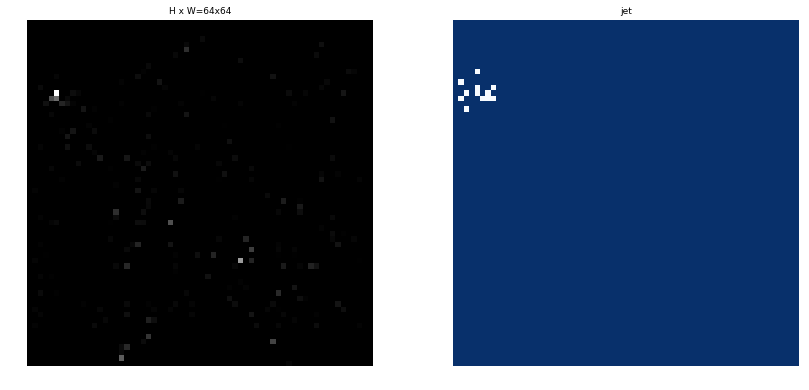

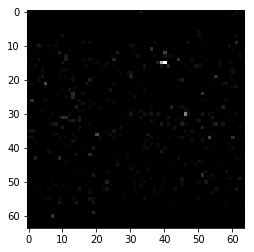

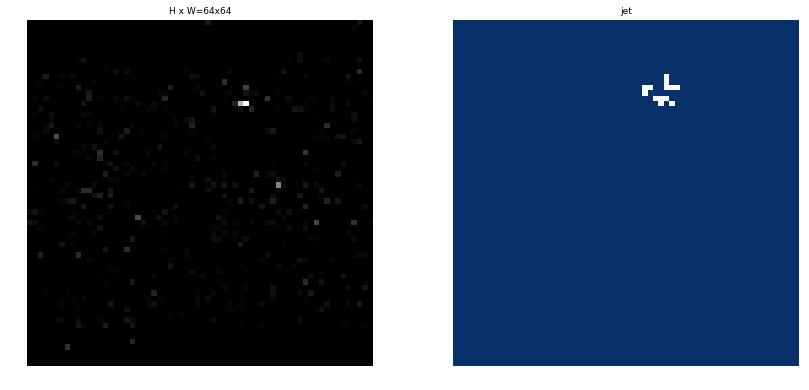

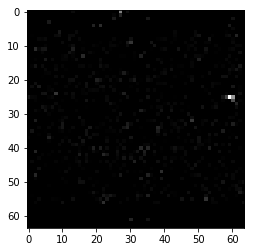

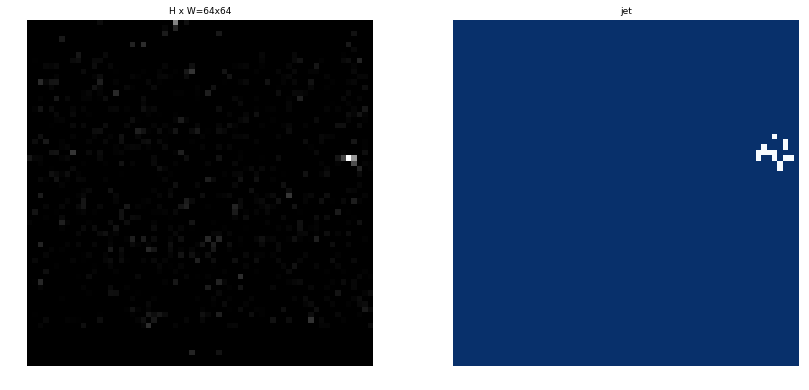

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    plt.imshow(image)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

## Detection

In [40]:
print(model.find_last()[1])

/home/camila/cs230/Jets_1/logs/jets20180312T2039/mask_rcnn_jets_4180.h5


In [169]:
class InferenceConfig(JetsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")

#model_path = model.find_last()[1]
model_path = 'logs/jets20180312T2039/mask_rcnn_jets_0840.h5'

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  logs/jets20180312T2039/mask_rcnn_jets_0840.h5


In [58]:
"""
Mask R-CNN
Display and Visualization Functions.

Copyright (c) 2017 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla
"""

import random
import itertools
import colorsys
import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import IPython.display

import utils


############################################################
#  Visualization
############################################################

def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interporlation to use for display.
    """
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(image.astype(np.uint8), cmap=cmap,
                   norm=norm, interpolation=interpolation)
        i += 1
    plt.show()


def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def display_instances(save_fig_name, image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    figsize: (optional) the size of the image.
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)

    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        #if scores[i] < 0.9:
        #      continue
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax.add_patch(p)

        # Label
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        x = random.randint(x1, (x1 + x2) // 2)
        caption = "{} {:.3f}".format(label, score) if score else label
        ax.text(x1, y1 + 8, caption,
                color='w', size=14, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    #plt.show()
    plt.savefig(save_fig_name)
    
def draw_rois(image, rois, refined_rois, mask, class_ids, class_names, limit=10):
    """
    anchors: [n, (y1, x1, y2, x2)] list of anchors in image coordinates.
    proposals: [n, 4] the same anchors but refined to fit objects better.
    """
    masked_image = image.copy()

    # Pick random anchors in case there are too many.
    ids = np.arange(rois.shape[0], dtype=np.int32)
    ids = np.random.choice(
        ids, limit, replace=False) if ids.shape[0] > limit else ids

    fig, ax = plt.subplots(1, figsize=(12, 12))
    if rois.shape[0] > limit:
        plt.title("Showing {} random ROIs out of {}".format(
            len(ids), rois.shape[0]))
    else:
        plt.title("{} ROIs".format(len(ids)))

    # Show area outside image boundaries.
    ax.set_ylim(image.shape[0] + 20, -20)
    ax.set_xlim(-50, image.shape[1] + 20)
    ax.axis('off')

    for i, id in enumerate(ids):
        color = np.random.rand(3)
        class_id = class_ids[id]
        # ROI
        y1, x1, y2, x2 = rois[id]
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              edgecolor=color if class_id else "gray",
                              facecolor='none', linestyle="dashed")
        ax.add_patch(p)
        # Refined ROI
        if class_id:
            ry1, rx1, ry2, rx2 = refined_rois[id]
            p = patches.Rectangle((rx1, ry1), rx2 - rx1, ry2 - ry1, linewidth=2,
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)
            # Connect the top-left corners of the anchor and proposal for easy visualization
            ax.add_line(lines.Line2D([x1, rx1], [y1, ry1], color=color))

            # Label
            label = class_names[class_id]
            ax.text(rx1, ry1 + 8, "{}".format(label),
                    color='w', size=11, backgroundcolor="none")

            # Mask
            m = utils.unmold_mask(mask[id], rois[id]
                                  [:4].astype(np.int32), image.shape)
            masked_image = apply_mask(masked_image, m, color)

    ax.imshow(masked_image)

    # Print stats
    print("Positive ROIs: ", class_ids[class_ids > 0].shape[0])
    print("Negative ROIs: ", class_ids[class_ids == 0].shape[0])
    print("Positive Ratio: {:.2f}".format(
        class_ids[class_ids > 0].shape[0] / class_ids.shape[0]))


# TODO: Replace with matplotlib equivalent?
def draw_box(image, box, color):
    """Draw 3-pixel width bounding boxes on the given image array.
    color: list of 3 int values for RGB.
    """
    y1, x1, y2, x2 = box
    image[y1:y1 + 2, x1:x2] = color
    image[y2:y2 + 2, x1:x2] = color
    image[y1:y2, x1:x1 + 2] = color
    image[y1:y2, x2:x2 + 2] = color
    return image


def display_top_masks(image, mask, class_ids, class_names, limit=4):
    """Display the given image and the top few class masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
    # Pick top prominent classes in this image
    unique_class_ids = np.unique(class_ids)
    mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                 for i in unique_class_ids]
    top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                    key=lambda r: r[1], reverse=True) if v[1] > 0]
    # Generate images and titles
    for i in range(limit):
        class_id = top_ids[i] if i < len(top_ids) else -1
        # Pull masks of instances belonging to the same class.
        m = mask[:, :, np.where(class_ids == class_id)[0]]
        m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
        to_display.append(m)
        titles.append(class_names[class_id] if class_id != -1 else "-")
    display_images(to_display, titles=titles, cols=limit + 1, cmap="Blues_r")


def plot_precision_recall(AP, precisions, recalls):
    """Draw the precision-recall curve.

    AP: Average precision at IoU >= 0.5
    precisions: list of precision values
    recalls: list of recall values
    """
    # Plot the Precision-Recall curve
    _, ax = plt.subplots(1)
    ax.set_title("Precision-Recall Curve. AP@50 = {:.3f}".format(AP))
    ax.set_ylim(0, 1.1)
    ax.set_xlim(0, 1.1)
    _ = ax.plot(recalls, precisions)


def plot_overlaps(gt_class_ids, pred_class_ids, pred_scores,
                  overlaps, class_names, threshold=0.5):
    """Draw a grid showing how ground truth objects are classified.
    gt_class_ids: [N] int. Ground truth class IDs
    pred_class_id: [N] int. Predicted class IDs
    pred_scores: [N] float. The probability scores of predicted classes
    overlaps: [pred_boxes, gt_boxes] IoU overlaps of predictins and GT boxes.
    class_names: list of all class names in the dataset
    threshold: Float. The prediction probability required to predict a class
    """
    gt_class_ids = gt_class_ids[gt_class_ids != 0]
    pred_class_ids = pred_class_ids[pred_class_ids != 0]

    plt.figure(figsize=(12, 10))
    plt.imshow(overlaps, interpolation='nearest', cmap=plt.cm.Blues)
    plt.yticks(np.arange(len(pred_class_ids)),
               ["{} ({:.2f})".format(class_names[int(id)], pred_scores[i])
                for i, id in enumerate(pred_class_ids)])
    plt.xticks(np.arange(len(gt_class_ids)),
               [class_names[int(id)] for id in gt_class_ids], rotation=90)

    thresh = overlaps.max() / 2.
    for i, j in itertools.product(range(overlaps.shape[0]),
                                  range(overlaps.shape[1])):
        text = ""
        if overlaps[i, j] > threshold:
            text = "match" if gt_class_ids[j] == pred_class_ids[i] else "wrong"
        color = ("white" if overlaps[i, j] > thresh
                 else "black" if overlaps[i, j] > 0
                 else "grey")
        plt.text(j, i, "{:.3f}\n{}".format(overlaps[i, j], text),
                 horizontalalignment="center", verticalalignment="center",
                 fontsize=9, color=color)

    plt.tight_layout()
    plt.xlabel("Ground Truth")
    plt.ylabel("Predictions")


def draw_boxes(image, boxes=None, refined_boxes=None,
               masks=None, captions=None, visibilities=None,
               title="", ax=None):
    """Draw bounding boxes and segmentation masks with differnt
    customizations.

    boxes: [N, (y1, x1, y2, x2, class_id)] in image coordinates.
    refined_boxes: Like boxes, but draw with solid lines to show
        that they're the result of refining 'boxes'.
    masks: [N, height, width]
    captions: List of N titles to display on each box
    visibilities: (optional) List of values of 0, 1, or 2. Determine how
        prominant each bounding box should be.
    title: An optional title to show over the image
    ax: (optional) Matplotlib axis to draw on.
    """
    # Number of boxes
    assert boxes is not None or refined_boxes is not None
    N = boxes.shape[0] if boxes is not None else refined_boxes.shape[0]

    # Matplotlib Axis
    if not ax:
        _, ax = plt.subplots(1, figsize=(12, 12))

    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    margin = image.shape[0] // 10
    ax.set_ylim(image.shape[0] + margin, -margin)
    ax.set_xlim(-margin, image.shape[1] + margin)
    ax.axis('off')

    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        # Box visibility
        visibility = visibilities[i] if visibilities is not None else 1
        if visibility == 0:
            color = "gray"
            style = "dotted"
            alpha = 0.5
        elif visibility == 1:
            color = colors[i]
            style = "dotted"
            alpha = 1
        elif visibility == 2:
            color = colors[i]
            style = "solid"
            alpha = 1

        # Boxes
        if boxes is not None:
            if not np.any(boxes[i]):
                # Skip this instance. Has no bbox. Likely lost in cropping.
                continue
            y1, x1, y2, x2 = boxes[i]
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                  alpha=alpha, linestyle=style,
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Refined boxes
        if refined_boxes is not None and visibility > 0:
            ry1, rx1, ry2, rx2 = refined_boxes[i].astype(np.int32)
            p = patches.Rectangle((rx1, ry1), rx2 - rx1, ry2 - ry1, linewidth=2,
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)
            # Connect the top-left corners of the anchor and proposal
            if boxes is not None:
                ax.add_line(lines.Line2D([x1, rx1], [y1, ry1], color=color))

        # Captions
        if captions is not None:
            caption = captions[i]
            # If there are refined boxes, display captions on them
            if refined_boxes is not None:
                y1, x1, y2, x2 = ry1, rx1, ry2, rx2
            x = random.randint(x1, (x1 + x2) // 2)
            ax.text(x1, y1, caption, size=11, verticalalignment='top',
                    color='w', backgroundcolor="none",
                    bbox={'facecolor': color, 'alpha': 0.5,
                          'pad': 2, 'edgecolor': 'none'})

        # Masks
        if masks is not None:
            mask = masks[:, :, i]
            masked_image = apply_mask(masked_image, mask, color)
            # Mask Polygon
            # Pad to ensure proper polygons for masks that touch image edges.
            padded_mask = np.zeros(
                (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
            padded_mask[1:-1, 1:-1] = mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))


def display_table(table):
    """Display values in a table format.
    table: an iterable of rows, and each row is an iterable of values.
    """
    html = ""
    for row in table:
        row_html = ""
        for col in row:
            row_html += "<td>{:40}</td>".format(str(col))
        html += "<tr>" + row_html + "</tr>"
    html = "<table>" + html + "</table>"
    IPython.display.display(IPython.display.HTML(html))


def display_weight_stats(model):
    """Scans all the weights in the model and returns a list of tuples
    that contain stats about each weight.
    """
    layers = model.get_trainable_layers()
    table = [["WEIGHT NAME", "SHAPE", "MIN", "MAX", "STD"]]
    for l in layers:
        weight_values = l.get_weights()  # list of Numpy arrays
        weight_tensors = l.weights  # list of TF tensors
        for i, w in enumerate(weight_values):
            weight_name = weight_tensors[i].name
            # Detect problematic layers. Exclude biases of conv layers.
            alert = ""
            if w.min() == w.max() and not (l.__class__.__name__ == "Conv2D" and i == 1):
                alert += "<span style='color:red'>*** dead?</span>"
            if np.abs(w.min()) > 1000 or np.abs(w.max()) > 1000:
                alert += "<span style='color:red'>*** Overflow?</span>"
            # Add row
            table.append([
                weight_name + alert,
                str(w.shape),
                "{:+9.4f}".format(w.min()),
                "{:+10.4f}".format(w.max()),
                "{:+9.4f}".format(w.std()),
            ])
    display_table(table)


In [53]:
import time
t = []
cont = 0
n = 1000


for i in range(n):
    image_id = random.choice(dataset_val.image_ids)
    image = images[train_cutoff + image_id]

    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
    
    start = time.time()
    results = model.detect([original_image], verbose=0)
    end = time.time()
    t.append(end-start)
    cont += end - start
    
    #r = results[0]
    #visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
    #                       dataset_val.class_names, r['scores'], ax=get_ax())
#print(t)
print(cont/n)

0.06475944519042968


468
Processing 1 images
image                    shape: (64, 64, 3)           min:    0.00000  max:  255.00000
molded_images            shape: (1, 64, 64, 3)        min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:   64.00000
{'rois': array([[24, 48, 31, 55],
       [46, 11, 53, 18],
       [21,  4, 28, 12],
       [19, 20, 27, 27],
       [ 7, 20, 14, 27]], dtype=int32), 'class_ids': array([1, 1, 1, 1, 1], dtype=int32), 'scores': array([0.99099076, 0.9778633 , 0.80890495, 0.7707731 , 0.7469715 ],
      dtype=float32), 'masks': array([[[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
  

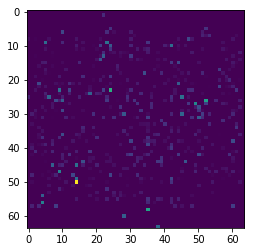

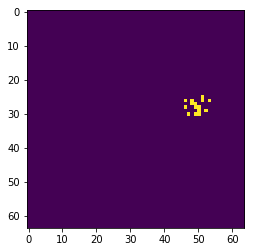

<Figure size 432x288 with 0 Axes>

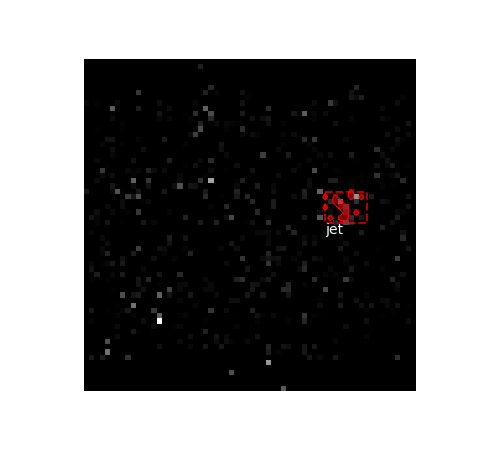

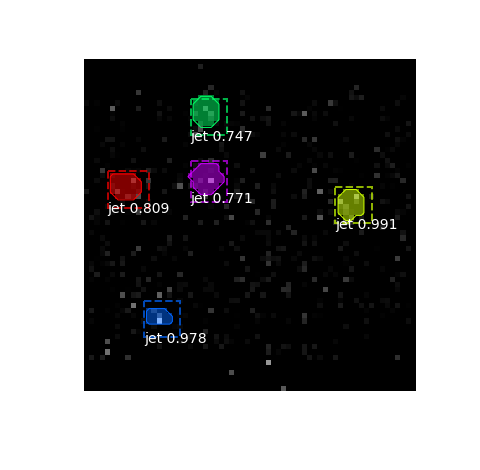

In [126]:
image_id = random.choice(dataset_val.image_ids)
#image_id = 430

raw_name = 'figures/'+str(image_id)+'_raw.png'
label_name = 'figures/'+str(image_id)+'_label.png'
model_name = 'figures/'+str(image_id)+'_model.png'
pred_name = 'figures/'+str(image_id)+'_pred.png'

image = images[train_cutoff + image_id]
print(image_id)
plt.imshow(image)
plt.savefig(raw_name)
plt.figure()
plt.imshow(labels[train_cutoff + image_id])
plt.savefig(label_name)
plt.figure()

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

'''
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
'''
display_instances(model_name, original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
display_instances(pred_name, original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

print(r)

In [129]:
scores = r['scores']
print(scores.shape[0])

5


Processing 1 images
image                    shape: (64, 64, 3)           min:    0.00000  max:  255.00000
molded_images            shape: (1, 64, 64, 3)        min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:   64.00000


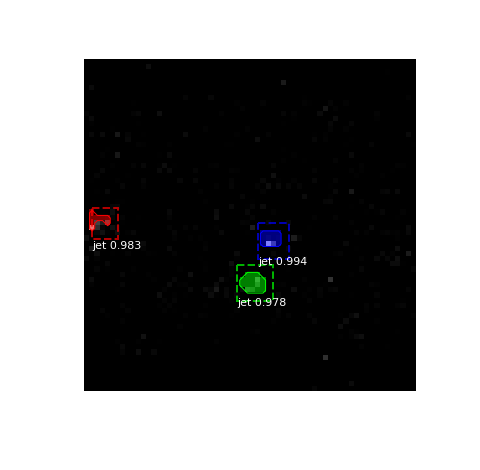

{'rois': array([[31, 33, 38, 39],
       [28,  1, 34,  6],
       [39, 29, 46, 36]], dtype=int32), 'class_ids': array([1, 1, 1], dtype=int32), 'scores': array([0.99435705, 0.9828012 , 0.9783558 ], dtype=float32), 'masks': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 

In [67]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

print(r)

In [12]:
def get_pT(image,r):
    n_masks = r['masks'].shape[2]
    pT = np.zeros((n_masks))

    for i_mask in range(n_masks):
        pT[i_mask] = np.sum(image * r['masks'][:,:,i_mask])
        
    return pT

In [88]:
def get_pT_2(image,r):
    n_masks = r['masks'].shape[2]
    pT = np.zeros((n_masks))
    
    for i_mask in range(n_masks):
        mask2 = np.zeros(image.shape)
        x1, y1, x2, y2 = r['rois'][i_mask]
        mask2[x1:(x2+1),y1:(y2+1)] = 1
        pT[i_mask] = np.sum(image * mask2)
        
    return pT

In [114]:
def get_pT_3(image,pred_box):
    x1, y1, x2, y2 = pred_box
        
    return np.sum(image[x1:(x2+1),y1:(y2+1)])

# Comparing number of jets with pT > 20 GeV

In [14]:
image_ids = dataset_val.image_ids
n = image_ids.shape[0]
print(n)

jet_thresh = 15.

cmat_dim = 5
cmat = np.zeros((cmat_dim, cmat_dim))

for image_id in dataset_val.image_ids:
    if image_id % 20 == 0:
        print(image_id)
        
    image = images[train_cutoff + image_id]
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
    
    gt_njet = gt_mask.shape[2]
    if gt_njet >= cmat_dim:
        gt_njet = cmat_dim - 1
    
    results = model.detect([original_image], verbose=0)
    r = results[0]
    
    pT = get_pT(image, r)

    r_njet = np.sum(pT >= jet_thresh)
    if r_njet >= cmat_dim:
        r_njet = cmat_dim - 1
        
    cmat[gt_njet, r_njet] += 1
    


1000
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980


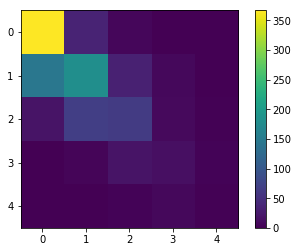

In [15]:
plt.imshow(cmat)
plt.colorbar()

In [58]:
print(cmat)
gt = labels[train_cutoff + image_id]

[[341.  60.   9.   0.   0.   0.   0.]
 [120. 213.  25.   7.   4.   0.   0.]
 [ 12.  70.  64.  15.   2.   1.   0.]
 [  0.  12.  17.   9.   5.   0.   0.]
 [  0.   0.   4.   7.   0.   0.   0.]
 [  0.   0.   1.   1.   0.   0.   0.]
 [  0.   0.   0.   0.   1.   0.   0.]]


(64, 64)


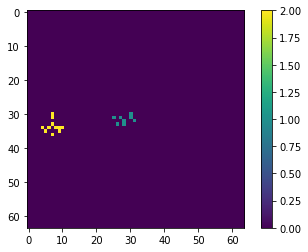

In [61]:
print(gt.shape)
plt.imshow(gt)
plt.colorbar()

In [78]:
image_ids = dataset_val.image_ids
n = image_ids.shape[0]
print(n)

results = np.zeros((n, 5))

for image_id in dataset_val.image_ids:
    if image_id % 20 == 0:
        print(image_id)
        
    image = images[train_cutoff + image_id]
    labels = labels[train_cutoff + image_id]
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
   
    ## number of jets in GT image
    gt_njet = gt_mask.shape[2] 
    
    ## pT of jets in GT image
    
    
    results = model.detect([original_image], verbose=0)
    r = results[0]
    

1000
0


IndexError: index 99001 is out of bounds for axis 0 with size 64

In [106]:
image_ids = dataset_val.image_ids
n = image_ids.shape[0]
print(n)

gt_list = []
pred_list = []

for image_id in dataset_val.image_ids:
    if image_id % 20 == 0:
        print(image_id)
        
    image = images[train_cutoff + image_id]
    
    gt =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
                   
    results = model.detect([gt[0]], verbose=0)
    r = results[0]
    
    gt_list.append(gt)
    pred_list.append(r)

1000
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980


In [107]:
np_gt = np.asarray(gt_list)
np_pred = np.asarray(pred_list)

np.save('ground_truth_weights2350.npy', np_gt)
np.save('prediction_weights2350.npy', np_pred)

# Comparing gt vs. predicted jets usig ROI to find pT of a Jet

In [101]:
image_ids = dataset_train.image_ids
n = image_ids.shape[0]
print(n)

n_jets = 0

for image_id in dataset_train.image_ids:
    if image_id % 20 == 0:
        print(image_id)
        
    #image = images[train_cutoff + image_id]
    image = images[image_id]
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)
            
    gt_njet = gt_mask.shape[2] ## number of jets in GT per image
    
    n_jets += gt_njet
    
print('total number jets:' + str(n_jets))

99000
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500
2520
2540
2560
2580
2600
2620
2640
2660
2680
2700
2720
2740
2760
2780
2800
2820
2840
2860
2880
2900
2920
2940
2960
2980
3000
3020
3040
3060
3080
3100
3120
3140
3160
3180
3200
3220
3240
3260
3280
3300
3320
3340
3360
3380
3400
3420
3440
3460
3480
3500
3520
3540
3560
3580
3600
3620
3640
3660
3680
3700
3720
3740
3760
3780
3800
3820
3840
3860
3880
3900
3920
3940
3960
3980
4000
4020
4040
4060
4080
4100
4120
4140
4160
4180


29160
29180
29200
29220
29240
29260
29280
29300
29320
29340
29360
29380
29400
29420
29440
29460
29480
29500
29520
29540
29560
29580
29600
29620
29640
29660
29680
29700
29720
29740
29760
29780
29800
29820
29840
29860
29880
29900
29920
29940
29960
29980
30000
30020
30040
30060
30080
30100
30120
30140
30160
30180
30200
30220
30240
30260
30280
30300
30320
30340
30360
30380
30400
30420
30440
30460
30480
30500
30520
30540
30560
30580
30600
30620
30640
30660
30680
30700
30720
30740
30760
30780
30800
30820
30840
30860
30880
30900
30920
30940
30960
30980
31000
31020
31040
31060
31080
31100
31120
31140
31160
31180
31200
31220
31240
31260
31280
31300
31320
31340
31360
31380
31400
31420
31440
31460
31480
31500
31520
31540
31560
31580
31600
31620
31640
31660
31680
31700
31720
31740
31760
31780
31800
31820
31840
31860
31880
31900
31920
31940
31960
31980
32000
32020
32040
32060
32080
32100
32120
32140
32160
32180
32200
32220
32240
32260
32280
32300
32320
32340
32360
32380
32400
32420
32440
32460
3248

56720
56740
56760
56780
56800
56820
56840
56860
56880
56900
56920
56940
56960
56980
57000
57020
57040
57060
57080
57100
57120
57140
57160
57180
57200
57220
57240
57260
57280
57300
57320
57340
57360
57380
57400
57420
57440
57460
57480
57500
57520
57540
57560
57580
57600
57620
57640
57660
57680
57700
57720
57740
57760
57780
57800
57820
57840
57860
57880
57900
57920
57940
57960
57980
58000
58020
58040
58060
58080
58100
58120
58140
58160
58180
58200
58220
58240
58260
58280
58300
58320
58340
58360
58380
58400
58420
58440
58460
58480
58500
58520
58540
58560
58580
58600
58620
58640
58660
58680
58700
58720
58740
58760
58780
58800
58820
58840
58860
58880
58900
58920
58940
58960
58980
59000
59020
59040
59060
59080
59100
59120
59140
59160
59180
59200
59220
59240
59260
59280
59300
59320
59340
59360
59380
59400
59420
59440
59460
59480
59500
59520
59540
59560
59580
59600
59620
59640
59660
59680
59700
59720
59740
59760
59780
59800
59820
59840
59860
59880
59900
59920
59940
59960
59980
60000
60020
6004

84260
84280
84300
84320
84340
84360
84380
84400
84420
84440
84460
84480
84500
84520
84540
84560
84580
84600
84620
84640
84660
84680
84700
84720
84740
84760
84780
84800
84820
84840
84860
84880
84900
84920
84940
84960
84980
85000
85020
85040
85060
85080
85100
85120
85140
85160
85180
85200
85220
85240
85260
85280
85300
85320
85340
85360
85380
85400
85420
85440
85460
85480
85500
85520
85540
85560
85580
85600
85620
85640
85660
85680
85700
85720
85740
85760
85780
85800
85820
85840
85860
85880
85900
85920
85940
85960
85980
86000
86020
86040
86060
86080
86100
86120
86140
86160
86180
86200
86220
86240
86260
86280
86300
86320
86340
86360
86380
86400
86420
86440
86460
86480
86500
86520
86540
86560
86580
86600
86620
86640
86660
86680
86700
86720
86740
86760
86780
86800
86820
86840
86860
86880
86900
86920
86940
86960
86980
87000
87020
87040
87060
87080
87100
87120
87140
87160
87180
87200
87220
87240
87260
87280
87300
87320
87340
87360
87380
87400
87420
87440
87460
87480
87500
87520
87540
87560
8758

In [96]:
image_ids = dataset_val.image_ids
n = image_ids.shape[0]
print(n)

jet_thresh = 20.
#jet_score = 0.90

cmat_dim = 7
cmat = np.zeros((cmat_dim, cmat_dim))
gt_n_jets = np.zeros((cmat_dim, cmat_dim))

for image_id in dataset_val.image_ids:
    if image_id % 20 == 0:
        print(image_id)
        
    image = images[train_cutoff + image_id]
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
            
    gt_njet = gt_mask.shape[2] ## number of jets in GT per image
    
    if gt_njet == 0:
        gt_n_jets[gt_njet, :] += 1
    else:
        gt_n_jets[gt_njet, :] += gt_njet
        
    results = model.detect([original_image], verbose=0)
    r = results[0]
    
    pT = get_pT_2(image, r)

    r_njet = np.sum(pT >= jet_thresh)
    if r_njet >= cmat_dim:
        r_njet = cmat_dim - 1
        
    cmat[gt_njet, r_njet] += 1

1000
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980


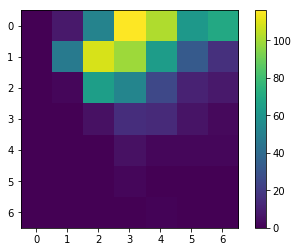

[[  0.   8.  52. 116. 102.  62.  70.]
 [  0.  48. 109.  99.  64.  33.  16.]
 [  0.   2.  65.  53.  25.  11.   8.]
 [  0.   0.   5.  15.  14.   6.   3.]
 [  0.   0.   0.   5.   2.   2.   2.]
 [  0.   0.   0.   2.   0.   0.   0.]
 [  0.   0.   0.   0.   1.   0.   0.]]


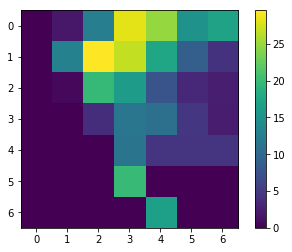

[[ 0.          1.95121951 12.68292683 28.29268293 24.87804878 15.12195122
  17.07317073]
 [ 0.         13.00813008 29.53929539 26.82926829 17.34417344  8.94308943
   4.33604336]
 [ 0.          0.6097561  19.81707317 16.15853659  7.62195122  3.35365854
   2.43902439]
 [ 0.          0.          3.87596899 11.62790698 10.85271318  4.65116279
   2.3255814 ]
 [ 0.          0.          0.         11.36363636  4.54545455  4.54545455
   4.54545455]
 [ 0.          0.          0.         20.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.         16.66666667  0.
   0.        ]]


In [66]:
plt.imshow(cmat)
plt.colorbar()
plt.show()
print(cmat)

plt.imshow(cmat/gt_n_jets*100)
plt.colorbar()
plt.show()

print(cmat/gt_n_jets*100)

In [25]:
image_ids = dataset_val.image_ids
n = image_ids.shape[0]
print(n)
score_thresh = 0.99
cmat_dim = 5
cmat = np.zeros((cmat_dim, cmat_dim))
for image_id in dataset_val.image_ids[0:50]:
    if image_id % 20 == 0:
        print(image_id)
        
    image = images[train_cutoff + image_id]
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
    
    gt_njet = gt_mask.shape[2]
    if gt_njet >= cmat_dim:
        gt_njet = cmat_dim - 1
    
    results = model.detect([original_image], verbose=0)
    r = results[0]
    
    scores = r["scores"]
    r_njet = np.sum(scores >= score_thresh)
    if r_njet >= cmat_dim:
        r_njet = cmat_dim - 1
        
    cmat[gt_njet, r_njet] += 1


1000
0
20
40


[[18.  8.  0.  0.  0.]
 [ 2. 13.  3.  0.  0.]
 [ 0.  5.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


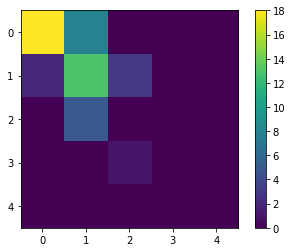

In [26]:
plt.imshow(cmat)
plt.colorbar()
print(cmat)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980


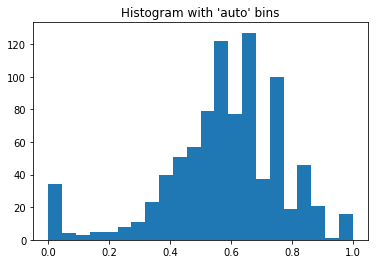

In [90]:
def compute_iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    yA = max(boxA[0], boxB[0])
    xA = max(boxA[1], boxB[1])
    yB = min(boxA[2], boxB[2])
    xB = min(boxA[3], boxB[3])
    
    # compute the area of intersection rectangle
    interArea = (xB - xA) * (yB - yA)
    
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    if (xB <= xA) or (yB <= yA):
        iou = 0
    else:
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
        iou = interArea / float(boxAArea + boxBArea - interArea)
    
    # return the intersection over union value
    return iou
	
image_ids = dataset_val.image_ids
n = image_ids.shape[0]

IoU = []


for image_id in dataset_val.image_ids:
    if image_id % 20 == 0:
        print(image_id)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
    results = model.detect([original_image], verbose=0)
    pred_boxes = results[0]['rois']

    for box in gt_bbox:
        iou_max = 0
        
        for pred_box in pred_boxes:
            #compute iou
            iou = compute_iou(box, pred_box)

            if iou > iou_max:
                iou_max = iou
        IoU.append(iou_max) 

plt.hist(np.array(IoU), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [14]:
print(np.median(IoU))

0.5915492957746479


In [172]:
image_ids = dataset_val.image_ids
n = image_ids.shape[0]
threshold = 0.3
tp = 0
fp = 0
total_boxes = 0
c = 0
test = True

for image_id in dataset_val.image_ids:
    if image_id % 20 == 0:
        print(image_id)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config,
                           image_id, use_mini_mask=False)
    results = model.detect([original_image], verbose=0)
    
    image = images[train_cutoff + image_id]
    
    pred_boxes = results[0]['rois']
    pred_scores = results[0]['scores']
    box_scores = []
    for i in range(len(pred_boxes)):
        box_scores.append((pred_boxes[i], pred_scores[i]))
        
    for pred_box in box_scores:
       # print(pred_box)
        pt_image = get_pT_3(image, pred_box[0])
        
        #if pt_image >= 20 and pred_box[1] >= 0.98:
        if test:          
            iou_max = 0
        
            for box in gt_bbox:
                #compute iou
                iou = compute_iou(box, pred_box[0])
                total_boxes += 1
                if iou > iou_max:
                    iou_max = iou
            #print(iou_max)
            if iou_max >= threshold:
                tp += 1
            else:
                fp += 1
        
        else:
            c += 1
            
precision = tp / (fp+tp)
recall = tp / total_boxes
print('precision: ', precision)
print('recall: ', recall)
print('F1: ', 2*precision*recall/(precision+recall))


0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
precision:  0.2459159859976663
recall:  0.30053475935828877
F1:  0.27049574843574525


In [171]:
print(c)
print(tp)
print(fp)
print(total_boxes)

3428
0
0
0


In [125]:
image_ids = dataset_val.image_ids
n = image_ids.shape[0]
threshold = 0.3
tp = 0
fp = 0
total_boxes = 0

for image_id in dataset_val.image_ids[:2]:
    if image_id % 20 == 0:
        print(image_id)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
    
    results = model.detect([original_image], verbose=0)
    r =results[0]
    
    print('results: ')
    print(r)
    
    gt_njet = gt_mask.shape[2]
    r_njet = r['masks'].shape[2]
    
    print('#jets gt, results: ' gt_njet + ' , ' + r_njet)
    
    pred_boxes = r['rois']
    pred_scores = r['scores']
    
    image = images[train_cutoff + image_id]
    
    for i in range(r_njet):
        pt_pred_jet = get_pT_3(image, pred_boxes[i])
        print('pred_box' + str(pred_box))
        print('pt image: ' + str(pt_image))
        
        iou_max = 0
        
        for box in gt_bbox:
            #compute iou
            iou = compute_iou(box, pred_boxes[i])
            total_boxes += 1
            if iou > iou_max:
                iou_max = iou
        #print(iou_max)
        if iou_max >= threshold:
            tp += 1
        else:
            fp += 1
    
    
    
    

    pt_image = get_pT_3(image, pred_box[ct])
    
    for pred_box in pred_boxes:
       # print(pred_box)
        pt_image = get_pT_3(image, pred_box)
        #print(pt_image)
        print(pred_score[ct])
        
        if pt_image < 20 and pred_score[ct] < 0.98:
            continue
            
        iou_max = 0
        
        for box in gt_bbox:
            #compute iou
            iou = compute_iou(box, pred_box)
            total_boxes += 1
            if iou > iou_max:
                iou_max = iou
        #print(iou_max)
        if iou_max >= threshold:
            tp += 1
        else:
            fp += 1
    
    ct += 1
        
precision = tp / (fp+tp)
recall = tp / total_boxes
print('precision: ', precision)
print('recall: ', recall)
print('F1: ', 2*precision*recall/(precision+recall))


0
0.9856668
0.9856668
0.9856668
0.9856668
0.98392695
0.98392695
0.98392695
0.98392695
0.9908642
0.9908642
0.98590964
0.98590964
0.9919642
0.9919642
0.9919642
0.9919642
0.97757906
0.97757906
0.97757906
0.97757906
0.997521
0.997521
0.997521
0.997521
0.9930896
0.9930896
0.9930896
0.9930896
0.9800427
0.9800427
0.9800427
0.995874
0.995874
0.995874
0.995874
0.9791981
0.9791981
0.9791981
0.9791981
0.99579227
0.99579227
0.99579227
0.94944406
0.94944406
0.94944406
0.9946683
0.9946683
0.9944494
0.9944494
0.9944494
0.995346
0.995346
0.99420714
0.99420714
0.9907934
0.9907934
0.9907934
0.9907934
0.9907934
0.9547826
0.9547826
0.9547826
0.99080545
0.99080545
20
0.9954592
0.9954592
0.9819264
0.9819264
0.9819264
0.9819264
0.9819264
0.9819264
0.9819264
0.99004364
0.99004364
0.95436686
0.95436686
0.95436686
0.95436686
0.97323567
0.97323567
0.9920546
0.9920546
0.9926381
0.9926381
0.9915006
0.9915006
0.9915006
0.9915006
0.97981983
0.9928169
0.9928169
0.997364
0.997364
0.997364
0.997364
0.97832096
0.9783209

KeyboardInterrupt: 

In [123]:
print(tp)
print(fp)
print(total_boxes)

825
797
1995
